<a href="https://www.kaggle.com/code/botondcsatls/plant-disease-classification?scriptVersionId=155429943" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Plant-Doc: Plant disease detection

Detecting plant diseases from images is of paramount importance in the realm of agriculture and food security since diseases pose a significant threat to crop yields, leading to substantial economic losses and potentially compromised food supplies. The ability to identify diseases in plants through image analysis provides a powerful tool for early intervention and targeted treatment, preventing the spread of diseases, minimizing crop damage, and ensuring the health and vitality of agricultural ecosystems. 

The goal of this project is to build an image classifier thatcan determine the disease of a plant and works for all plants in the dataset provided by this study: https://github.com/pratikkayal/PlantDoc-Dataset/tree/master

In [1]:
import numpy as np
import pandas as pd 
import cv2

import os
from os import listdir, makedirs
from os.path import join, exists, expanduser

from PIL import Image

from pathlib import Path
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalCrossentropy
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input, decode_predictions
%pylab inline


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Data preprocessing

Let's check some examples of the training images

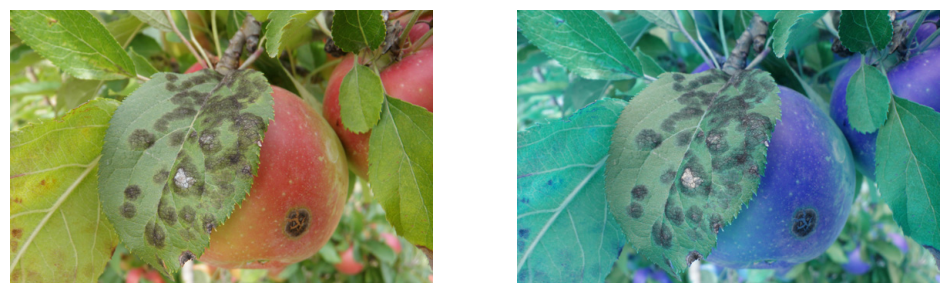

In [2]:
pil_kep = Image.open('/kaggle/input/datamining-plantdoc/PlantDoc-Dataset-master/train/Apple Scab Leaf/01Apple-scab-2-Venturia-inaequalis.ashx_w=600h=408bc=ffffff.jpg')
cv2_kep = cv2.imread('/kaggle/input/datamining-plantdoc/PlantDoc-Dataset-master/train/Apple Scab Leaf/01Apple-scab-2-Venturia-inaequalis.ashx_w=600h=408bc=ffffff.jpg')

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.imshow(pil_kep)
plt.axis('off')

plt.subplot(222)
plt.imshow(cv2_kep)
plt.axis('off')
plt.show()

In [3]:
cv2_kep.shape

(355, 549, 3)

### Batch Size:
With a small dataset, using a small batch size is usually beneficial this allow the model to see more variations in the data and can help prevent overfitting. 

### Augmentation
I am using data augmentation, which is a good strategy for artificially increasing the size of the training dataset. After cheking the data, in this case a lot of transformations are possible, since the leaves can be in any orientation, we can zoome in ect., the diseaseses are recognisable

Normally I used the following preprocess function when I used ResNet50, but in this case I used the built-in function of `keras` to make sure the inputs are correct


In [4]:
def imagenet_convert(img):
    img  = img.astype(float)[...,::-1] # RGB --> BGR
    img -= [103.939, 116.779, 123.68]
    return img

I used the `Keras`'s`ImageDataGenerator` and `flow_from_directory` built in functions, they automatically do the labeling and resizing of the images

In [5]:
batch=4

train_datagenerator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        #shear_range=0.2,
                                        rotation_range=20,
                                        width_shift_range=.1,
                                        height_shift_range=.1,
                                        zoom_range=[0.8, 1.2],
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode="nearest")
        
test_datagenerator  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagenerator = train_datagenerator.flow_from_directory(
        '/kaggle/input/datamining-plantdoc/PlantDoc-Dataset-master/train',
        target_size=(224, 224),
        batch_size=batch,
        class_mode='categorical',
        shuffle=True)

test_datagenerator = test_datagenerator.flow_from_directory(
        '/kaggle/input/datamining-plantdoc/PlantDoc-Dataset-master/test',
        target_size=(224, 224),
        batch_size=batch,
        class_mode='categorical',
        shuffle=True)


Found 2334 images belonging to 27 classes.
Found 236 images belonging to 27 classes.


In [6]:
print(train_datagenerator.class_indices)

{'Apple Scab Leaf': 0, 'Apple leaf': 1, 'Apple rust leaf': 2, 'Bell_pepper leaf': 3, 'Bell_pepper leaf spot': 4, 'Blueberry leaf': 5, 'Cherry leaf': 6, 'Corn Gray leaf spot': 7, 'Corn leaf blight': 8, 'Corn rust leaf': 9, 'Peach leaf': 10, 'Potato leaf early blight': 11, 'Potato leaf late blight': 12, 'Raspberry leaf': 13, 'Soyabean leaf': 14, 'Squash Powdery mildew leaf': 15, 'Strawberry leaf': 16, 'Tomato Early blight leaf': 17, 'Tomato Septoria leaf spot': 18, 'Tomato leaf': 19, 'Tomato leaf bacterial spot': 20, 'Tomato leaf late blight': 21, 'Tomato leaf mosaic virus': 22, 'Tomato leaf yellow virus': 23, 'Tomato mold leaf': 24, 'grape leaf': 25, 'grape leaf black rot': 26}


In [7]:
print(test_datagenerator.class_indices)

{'Apple Scab Leaf': 0, 'Apple leaf': 1, 'Apple rust leaf': 2, 'Bell_pepper leaf': 3, 'Bell_pepper leaf spot': 4, 'Blueberry leaf': 5, 'Cherry leaf': 6, 'Corn Gray leaf spot': 7, 'Corn leaf blight': 8, 'Corn rust leaf': 9, 'Peach leaf': 10, 'Potato leaf early blight': 11, 'Potato leaf late blight': 12, 'Raspberry leaf': 13, 'Soyabean leaf': 14, 'Squash Powdery mildew leaf': 15, 'Strawberry leaf': 16, 'Tomato Early blight leaf': 17, 'Tomato Septoria leaf spot': 18, 'Tomato leaf': 19, 'Tomato leaf bacterial spot': 20, 'Tomato leaf late blight': 21, 'Tomato leaf mosaic virus': 22, 'Tomato leaf yellow virus': 23, 'Tomato mold leaf': 24, 'grape leaf': 25, 'grape leaf black rot': 26}


Originally there was one more category in the train folder, but these images did not make sense and did not have test data, so I deleted them.

# Model building 

I used a pre-trained `ResNet50` with imagenet weights as a feature extractor for additional layers since we have limited amount of data. I will first train only the newly added top layers with a higher learning rate, and then the last block of ResNet with a lower learning rate.




## Transfer learning from pre-trained weights

In [8]:
pretrained_model = ResNet50(weights='imagenet',include_top=False,input_shape=(224, 224, 3)) 

94765736/94765736 [==============================] - 0s 0us/step


In [9]:
pretrained_model.trainable = False

I used `GlobalAvaragePooling2D` insted of `Flatten` since it works better, Global Pooling condenses all of the feature maps into a single one, pooling all of the relevant information into a single map insted of just simply flattening a feature map into a vector.

In [10]:
x = pretrained_model.output

x = GlobalAveragePooling2D(name="avg_pool")(x) # add a global spatial average pooling layer
x = BatchNormalization(name="bn1")(x)

x = Dense(512, activation='relu',
         #kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), # fully-connected layer
         name="Dense512")(x)
x = BatchNormalization(name="bn2")(x)
x = Dropout(0.30, seed=42,name="top_dropout1")(x)

x = Dense(128, activation='relu',name="Dense128")(x)
x = BatchNormalization(name="bn3")(x)
x = Dropout(0.30, seed=137,name="top_dropout2")(x)
predictions = Dense(27, activation='softmax',name="preds")(x)
model_improved = Model(inputs=pretrained_model.input, outputs=predictions)

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

## Callbacks
Callbacks can be usefull when fitting the model, especially if one can avoide overfitting. I used three callbacks:

- ReduceLROnPlateau: with this callback it is able to update the Learning rate if the monitored metrics does not change in the gives epochs, it helps speed up the training.

- EarlyStopping: with this callback we can stop the training if the monitored matrics does not change, it helps avoid overfitting

- LearningRateScheduler: it is similar to the first one I ised, but in this case we can set manually the laerning rate during the epochs


In [12]:
#Callbacks
rlrop = ReduceLROnPlateau(monitor='val_loss', 
                          mode='min', 
                          patience=4, 
                          factor=0.3, 
                          min_lr=1e-6, 
                          verbose=1)

early_stopping = EarlyStopping(monitor='accuracy', mode='min', patience=5, restore_best_weights=True)

def lr_schedule(epoch):
    lr = 0.0008
    weight_decay = 0.00016
    if epoch > 5:
        lr *= 0.5
        weight_decay = 0.00005
    if epoch > 10:
        lr *= 0.5
        weight_decay = 0.000015
    if epoch > 15:
        lr *= 0.5
        weight_decay = 0.000005
    return lr

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

## Choice of Optimizer
To build this classifier,I am using **RMSprop** instead of Adam due to its ability to handle sparse gradients. Since this is a multilabel task I am dealing with sparse gradients due to multiple categories and sub categories. The dataset has a varying complexity and different number of images in each class so RMSprop may be better that Adam because its adaptive learning rate mechanism.

In [13]:
model_improved.compile(optimizer=Adam(learning_rate = 8e-4,weight_decay = 5e-5),
              loss=CategoricalCrossentropy(),
              #loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


train=model_improved.fit(train_datagenerator,
                   steps_per_epoch=len(train_datagenerator),
                   validation_data=test_datagenerator,
                   validation_steps = len(test_datagenerator),
                   epochs=25,
                   callbacks=[lr_scheduler])

Epoch 1/25
584/584 [==============================] - 104s 151ms/step - loss: 3.2882 - accuracy: 0.1517 - val_loss: 2.6329 - val_accuracy: 0.2500 - lr: 8.0000e-04
Epoch 2/25
584/584 [==============================] - 62s 107ms/step - loss: 2.6720 - accuracy: 0.2434 - val_loss: 2.2076 - val_accuracy: 0.3475 - lr: 8.0000e-04
Epoch 3/25
584/584 [==============================] - 62s 106ms/step - loss: 2.4700 - accuracy: 0.2939 - val_loss: 2.3627 - val_accuracy: 0.3178 - lr: 8.0000e-04
Epoch 4/25
584/584 [==============================] - 62s 106ms/step - loss: 2.3452 - accuracy: 0.3081 - val_loss: 2.1085 - val_accuracy: 0.3898 - lr: 8.0000e-04
Epoch 5/25
584/584 [==============================] - 62s 106ms/step - loss: 2.2261 - accuracy: 0.3333 - val_loss: 1.9374 - val_accuracy: 0.4153 - lr: 8.0000e-04
Epoch 6/25
584/584 [==============================] - 62s 107ms/step - loss: 2.1765 - accuracy: 0.3410 - val_loss: 1.9994 - val_accuracy: 0.3898 - lr: 8.0000e-04
Epoch 7/25
584/584 [=======

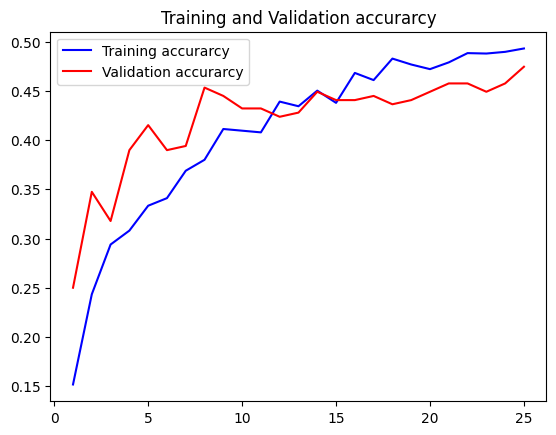

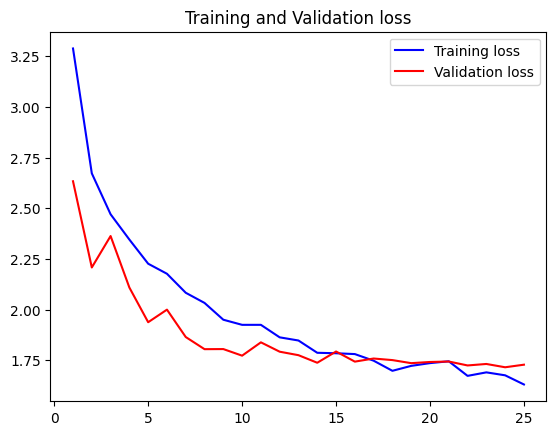

In [14]:
from keras.callbacks import History 
#history = History()

acc = train.history['accuracy']
val_acc = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']


epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#### It is very important that The BatchNormalization layers of a pretrained layer need to be kept frozen during training unless the first epoch after unfreezing the base network will reduce accuracy.

In [15]:
def unfreeze_model(model):

    for layer in model.layers[-41:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=1e-5,weight_decay = 5e-7), loss=CategoricalCrossentropy(from_logits=False), metrics=["accuracy"]
    )
    
unfreeze_model(model_improved)

In [16]:
for i, layer in enumerate(model_improved.layers):
        print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [17]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
train=model_improved.fit(train_datagenerator,
                   steps_per_epoch=len(train_datagenerator),#//batch,
                   validation_data=test_datagenerator,
                   validation_steps = len(test_datagenerator),#//batch,
                   epochs=30,
                   callbacks=[early_stopping,rlrop])

Epoch 1/30
584/584 [==============================] - 76s 111ms/step - loss: 1.6662 - accuracy: 0.4816 - val_loss: 1.6513 - val_accuracy: 0.4873 - lr: 1.0000e-05
Epoch 2/30
584/584 [==============================] - 62s 106ms/step - loss: 1.5975 - accuracy: 0.5184 - val_loss: 1.6098 - val_accuracy: 0.4915 - lr: 1.0000e-05
Epoch 3/30
584/584 [==============================] - 62s 106ms/step - loss: 1.5724 - accuracy: 0.5103 - val_loss: 1.7321 - val_accuracy: 0.4788 - lr: 1.0000e-05
Epoch 4/30
584/584 [==============================] - 62s 106ms/step - loss: 1.5690 - accuracy: 0.5257 - val_loss: 1.6986 - val_accuracy: 0.4746 - lr: 1.0000e-05
Epoch 5/30
584/584 [==============================] - 62s 106ms/step - loss: 1.5019 - accuracy: 0.5308 - val_loss: 1.5640 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 6/30
584/584 [==============================] - 62s 106ms/step - loss: 1.4996 - accuracy: 0.5308 - val_loss: 1.6172 - val_accuracy: 0.4958 - lr: 1.0000e-05
Epoch 7/30
584/584 [========

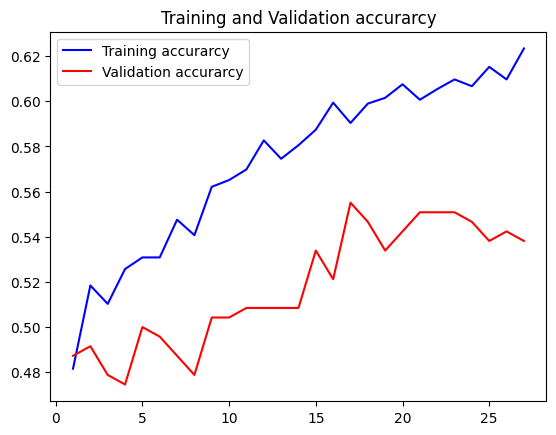

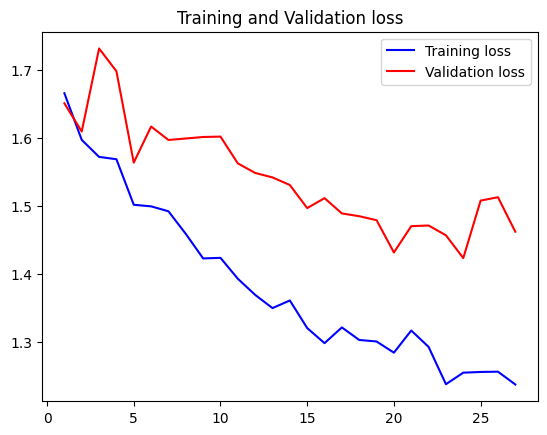

In [18]:
from keras.callbacks import History 
#history = History()

acc = train.history['accuracy']
val_acc = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']


epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

### This last run does not show the best results, but I wanted to illustrate that with a very low learning rate, we can achieve training and test accuracy close to each other, if we train much longer, we can achieve training accuracy around 90 percent and test accuracy around 70 percent

## Methods:

- I used a pre-trained `ResNet50` with imagenet weights as a feature extractor for additional layers. After several transfer learning projects, I can say that this was the deepest finetuning I have used; after the base natwork I used several `Dens`, `BatchNormalistaion` and `Dropout` layers, even using regularization for the Dens layer weights

-  The biggest task was to improve the low accuracy of the test set, for this I tried several loss functions and optimizers during the training and I also used callbacks; EarlyStopping and LearningRateScheduler to avoid overfitting.

## Results:

- This notebook contains the best model, I first tried a very simple model; I just replaced the last layer of a ResNet. With this I could achieve really fast a training accuracy above 90 $\%$, but the validation_accuracy was very low (around 45 $\%$).  I added more layers step by step to improve the performance on the test set, in each step the model was slower to reach 95% training_accuracy due to the regularisation techniques, but in return, the model performed better on validation_set.
- With the addtional  (2 Dropout, 3 BatchNormalisation and 3 Dens) layers with kernel regulazisation, using LR scheduleing during training I was able to achieve $>$ 93 $%$ training, and $\approx$ 70 $%$ test set accuracy by first training only the top layers with a higher learning rate and then including the last block of ResNet in the training with a lower learning rate.

## Conclusion
I think that this data set is not suitable for making an accurate plant disease classification. I tried the model on other data, trained and tested it on the PlantVillage dataset (which is also available on Kaggle) and got over 90% accuracy on both the training and "test" datasets even after simplifying the model. This dataset consists of about 87K rgb images of healthy and diseased crop leaves which is categorized into 38 different classes so an order of magnitude more that ours. Obviously the PlantVillage is a different dataset, the leaves are photographed separately, so less suitable to be "field applicable" (I mean photographing the plants and diseased leaves in their natural habitats). 

